In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io, time, os, logging
import tempfile
import re

### Load surveys for 2011 - 2015, 2017 - 2025 (2016 has a different folder format)

In [3]:

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

def find_csv_in_dir(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                return os.path.join(root, file)
    raise FileNotFoundError(f"No CSV found in {directory}")

available_years = range(2011, 2026)
dfs = {}
max_retries = 10
base_delay = 30

for year in available_years:
    url = f'https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-{year}.zip'
    extract_path = os.path.join(tempfile.gettempdir(), f'survey_{year}')
    print(f"\n📦 Processing {year}...")

    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, headers=headers, stream=True, timeout=60)
            content_type = r.headers.get('Content-Type', '')

            if r.status_code == 429:
                retry_after = int(r.headers.get('Retry-After', base_delay))
                print(f"⏳ Rate limited. Waiting {retry_after} seconds before retrying...")
                time.sleep(retry_after)
                continue

            if r.status_code == 200 and 'zip' in content_type:
                z = zipfile.ZipFile(io.BytesIO(r.content))
                z.extractall(extract_path)

                csv_path = find_csv_in_dir(extract_path)
                df = pd.read_csv(csv_path, encoding='ISO-8859-1')
                df['year'] = year
                dfs[year] = df
                print(f"✅ Loaded {year} survey with {len(df)} rows.")
                break
            else:
                print(f"❌ Failed for {year}: Status {r.status_code}, Content-Type {content_type}")
                break

        except zipfile.BadZipFile:
            print(f"⚠️ Invalid ZIP file for {year}. Attempt {attempt}/{max_retries}")
        except Exception as e:
            print(f"⚠️ Error on attempt {attempt}/{max_retries} for {year}: {e}")

        wait = base_delay * (2 ** (attempt - 1))
        print(f"🔁 Retrying in {wait} seconds...")
        time.sleep(wait)


📦 Processing 2011...
✅ Loaded 2011 survey with 2814 rows.

📦 Processing 2012...
✅ Loaded 2012 survey with 6244 rows.

📦 Processing 2013...


/var/folders/xz/3l5pw91d3_388t5z0w3_5dmw0000gn/T/ipykernel_15458/2533211471.py:38: DtypeWarning: Columns (46,48,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='ISO-8859-1')


✅ Loaded 2013 survey with 9743 rows.

📦 Processing 2014...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2014 survey with 7644 rows.

📦 Processing 2015...


/var/folders/xz/3l5pw91d3_388t5z0w3_5dmw0000gn/T/ipykernel_15458/2533211471.py:38: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='ISO-8859-1')


✅ Loaded 2015 survey with 26087 rows.

📦 Processing 2016...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2016 survey with 56030 rows.

📦 Processing 2017...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2017 survey with 51392 rows.

📦 Processing 2018...


/var/folders/xz/3l5pw91d3_388t5z0w3_5dmw0000gn/T/ipykernel_15458/2533211471.py:38: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='ISO-8859-1')


✅ Loaded 2018 survey with 98855 rows.

📦 Processing 2019...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2019 survey with 88883 rows.

📦 Processing 2020...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2020 survey with 64461 rows.

📦 Processing 2021...
✅ Loaded 2021 survey with 83439 rows.

📦 Processing 2022...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2022 survey with 73268 rows.

📦 Processing 2023...
✅ Loaded 2023 survey with 89184 rows.

📦 Processing 2024...
⏳ Rate limited. Waiting 30 seconds before retrying...
⏳ Rate limited. Waiting 30 seconds before retrying...
✅ Loaded 2024 survey with 65437 rows.

📦 Processing 2025...
✅ Loaded 2025 survey with 49123 rows.


### Extract dataframes for each year

In [4]:
for year, df in dfs.items():
    globals()[f'df_{year}'] = df

### Remove unnamed columns

In [5]:
pd.set_option('display.max_columns', None)

def drop_unnamed_columns(df):
    """Drops columns that start with 'Unnamed:' from a DataFrame."""
    cols_to_drop = [col for col in df.columns if re.match(r'Unnamed: \d+', col)]
    if cols_to_drop:
        print(f"Dropping columns: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
    return df

# Drop unnamed columns from each DataFrame in the dictionary
for year, df in dfs.items():
    dfs[year] = drop_unnamed_columns(df)
    print(f"DataFrame for year {year} after dropping unnamed columns:")
    display(dfs[year].head())

Dropping columns: ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62']
DataFrame for year 2011 after dropping unnamed columns:


,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,How likely is it that a recommendation you make will be acted upon?,What is your involvement in purchasing? You can choose more than 1.,What types of purchases are you involved in?,"What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011?",What type of project are you developing?,Which languages are you proficient in?,What operating system do you use the most?,Please rate your job/career satisfaction,"Including bonus, what is your annual compensation in USD?",Which technology products do you own? (You can choose more than one),"In the last 12 months, how much money have you spent on personal technology-related purchases?",Which of our sites do you frequent most?,year
0,Response,Response,Response,Response,Response,Response,Response,Response,Influencer,Hardware,"<$10,000",Response,Java,Response,Response,Response,iPhone,Response,Response,2011
1,Africa,NaN,< 20,<2,Consulting,Start Up (1-25),Web Application Developer,Not in a million years,NaN,NaN,NaN,Mobile,NaN,Linux,FML,Student / Unemployed,iPhone,<$100,NaN,2011
2,Other Europe,NaN,25-29,41310,Software Products,Mature Small Business (25-100),Server Programmer,It's been known to happen,NaN,NaN,NaN,Enterprise,Java,Windows 7,So happy it hurts,NaN,iPhone,$251-$500,Stack Overflow,2011
3,India,NaN,25-29,41435,Software Products,Mid Sized (100-999),Server Programmer,Unless it's stoopid it gets done,NaN,NaN,NaN,SaaS,Java,Linux,NaN,NaN,NaN,NaN,NaN,2011
4,Germany,NaN,< 20,41310,Foundation / Non-Profit,Student,Student,It's been known to happen,NaN,NaN,"<$10,000",Other,Java,Linux,I enjoy going to work,Student / Unemployed,NaN,"$501-$1,000",Stack Overflow,2011


Dropping columns: ['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 43', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 74']
DataFrame for year 2012 after dropping unnamed columns:


,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),What types of purchases are you involved in?,"What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011?",What type of project are you developing?,Which languages are you proficient in?,Which desktop operating system do you use the most?,What best describes your career / job satisfaction?,"Including bonus, what is your annual compensation in USD?",Have you visited / Are you aware of Stack Overflow Careers?,Do you have a Stack Overflow Careers Profile?,"You answered you don't have a Careers profile, can you elaborate why?",Which technology products do you own? (You can choose more than one),"In the last 12 months, how much money have you spent on personal technology-related purchases?",Please rate the advertising you've seen on Stack Overflow,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,Which of our sites do you frequent most?,year
0,Response,Response,Response,Response,Response,Response,Response,Influencer,Hardware,Response,Response,Java,Response,Response,Response,Response,Response,Response,iPhone,Response,The ads are relevant,Open-Ended Response,Response,Response,2012
1,India,NaN,20-24,<2,Consulting,"Fortune 1000 (1,000+)",Server Programmer,Influencer,Hardware,"<$10,000",SaaS,Java,Linux,Love my job,"<$20,000",Yes,"No, but I want one! (Please provide email and ...",NaN,iPhone,"$501-$1,000",NaN,NaN,NaN,NaN,2012
2,Germany,NaN,25-29,<2,Other,Mature Small Business (25-100),Embedded Application Developer,NaN,NaN,Don't know,Mobile,NaN,Windows 7,I enjoy going to work,"$20,000 - $40,000",No,No thank you,Thought Careers site was just about finding a ...,NaN,$100-$250,Neutral,NaN,Don't have an account,Stack Overflow,2012
3,United Kingdom,NaN,20-24,41070,Finance / Banking,Mature Small Business (25-100),Web Application Developer,Influencer,Hardware,"$25,001 - $40,000",Web Platform,NaN,Mac OS X,I enjoy going to work,"$20,000 - $40,000",Yes,No thank you,Thought Careers site was just about finding a ...,iPhone,"$1,001-$2,000",Neutral,NaN,1,Stack Overflow,2012
4,France,NaN,20-24,40944,Software Products,Mature Small Business (25-100),Embedded Application Developer,NaN,NaN,NaN,Mobile,Java,Linux,I'm not happy in my job,"$20,000 - $40,000",Yes,"No, but I want one! (Please provide email and ...",NaN,NaN,"$1,001-$2,000",Agree,None !,Don't have an account,Stack Overflow,2012


Dropping columns: ['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 73', 'Unnamed: 74', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 78', 'Unnamed: 79', 'Unnamed: 80', 'Unnamed: 83', 'Unnamed: 84', 'Unnam

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,How many people work for your company?,Which of the following best describes your occupation?,"Including yourself, how many developers are employed at your company?",How large is the team that you work on?,What other departments / roles do you interact with regularly?,"If your company has a native mobile app, what platforms do you support?","If you make a software product, how does your company make money? (You can choose more than one)","In an average week, how do you spend your time?",What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),What types of purchases are you involved in?,"What is your budget for outside expenditures (hardware, software, consulting, etc) for 2013?",Which of the following languages or technologies have you used significantly in the past year?,Which technologies are you excited about?,Which desktop operating system do you use the most?,"Please rate how important each of the following characteristics of a company/job offer are to you. Please select a MAXIMUM of 3 items as ""Non-Negotiables"" to help us identify the most important items, those where you would never consider a company if they didn't meet them.",Have you changed jobs in the last 12 months?,What best describes your career / job satisfaction?,"Including bonus, what is your annual compensation in USD?",Which technology products do you own? (You can choose more than one),"In the last 12 months, how much money have you spent on personal technology-related purchases?",Please rate the advertising you've seen on Stack Overflow,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,year
0,Response,Response,Response,Response,Response,Response,Response,Response,Response,System Administrators,iPhone,Advertising,Developing new features,I can recommend or request products,Hardware,Response,C,Node.js,Response,High Base Compensation,Response,Response,Response,iPhone,Response,The ads are relevant,Open-Ended Response,Response,Read other people's questions to solve my prob...,2013
1,United Kingdom,NaN,35-39,6/10/2013,Finance / Banking,101-999,Enterprise Level Services,100,4/8/2013,System Administrators,iPhone,NaN,10-20 hours,NaN,NaN,NaN,NaN,NaN,Windows 7,Non-Negotiable,No,It's a paycheck,"$80,000 - $100,000",iPhone,$100-$250,Neutral,NaN,Don't have an account,Read other people's questions to solve my prob...,2013
2,United States of America,Oregon,25-29,6/10/2013,Retail,101-999,Back-End Web Developer,6/15/2013,4/8/2013,System Administrators,iPhone,NaN,5-10 hours,NaN,NaN,"<$1,000",NaN,Node.js,Windows 7,Very Important,No,It's a paycheck,"$20,000 - $40,000",NaN,$251-$500,Disagree,"StackOverflow themselves, Careers 2.0 (SO also...",1,Read other people's questions to solve my prob...,2013
3,United States of America,Wisconsin,51-60,11,Software Products,26-100,Enterprise Level Services,6/15/2013,Just me!,System Administrators,NaN,NaN,5-10 hours,I can recommend or request products,NaN,Don't know,NaN,NaN,Windows 7,Very Important,No,I'm not happy in my job,"$120,000 - $140,000",NaN,">$3,000",Neutral,don't recall seeing ads on Stack Overflow,Don't have an account,Read other people's questions to solve my prob...,2013
4,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013


Dropping columns: ['Unnamed: 1', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 73', 'Unnamed: 74', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 78', 'Unnamed: 79', 'Unnamed: 80', 'Unnamed: 81', 'Unnamed: 84', 'Unnamed: 88', 'Unnamed: 89', 'Unnamed: 90', 'Unname

,What Country do you live in?,Which US State or Territory do you live in?,How old are you?,What is your gender?,How many years of IT/Programming experience do you have?,Which of the following best describes your occupation?,"Including bonus, what is your annual compensation in USD?",How would you best describe the industry you currently work in?,How many developers are employed at your company?,Do you work remotely?,Do you enjoy working remotely?,Where do you work remotely most of the time?,"If your company has a native mobile app, what platforms do you support?","In an average week, how do you spend your time at work?",What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),What types of purchases are you involved in?,"What is your budget for outside expenditures (hardware, software, consulting, etc) for 2014?",Which of the following languages or technologies have you used significantly in the past year?,Which technologies are you excited about?,Which desktop operating system do you use the most?,Which technology products do you own? (You can choose more than one),Have you changed jobs in the last 12 months?,How did you find out about your current job?,Are you currently looking for a job or open to new opportunities?,How often are you contacted by recruiters?,How do you prefer to be contacted about job opportunities?,"In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond?",How often do you visit job boards?,Have you visited / Are you aware of Stack Overflow Careers 2.0?,Do you have a Stack Overflow Careers 2.0 Profile?,Please rate the advertising you've seen on Stack Overflow,Were you aware of the Apptivate contest?,Did you participate in the Apptivate contest?,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,How often do you find solutions to your programming problems on Stack Overflow without asking a new question?,year
0,Response,Response,Response,Response,Response,Response,Response,Response,Response,Response,Response,Response,iPhone,Developing new features,I can recommend or request products,Hardware,Response,C,Node.js,Response,iPhone,Response,Response,Response,Response,Email,Message is personalized to me,Response,Response,Response,The ads are relevant,Response,Response,Open-Ended Response,Response,Read other people's questions to solve my prob...,Response,2014
1,India,NaN,30-34,Female,6/10/2014,Back-End Web Developer,"$20,000 - $40,000",Finance / Banking,100,Occasionally,It's not my preference. I'd prefer to be in an...,A home office,iPhone,5-10 hours,I can recommend or request products,NaN,"$1,000 - $5,000",NaN,Node.js,Linux,NaN,No,Recruiter/Headhunter,No,A slightly less than insane amount,Most Preferred,To a large extent,NaN,No,Yes,Strongly Agree,No,No,NaN,500,Read other people's questions to solve my prob...,Almost Always,2014
2,Thailand,NaN,20-24,Male,<2,Back-End Web Developer,Student / Unemployed,Healthcare,NaN,Never,NaN,NaN,NaN,2-5 hours,NaN,Hardware,Don't know,NaN,Node.js,Ubuntu,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No thank you,Neutral,NaN,NaN,NaN,Don't have an account,Read other people's questions to solve my prob...,NaN,2014
3,Iran,NaN,25-29,Male,6/10/2014,Desktop Software Developer,"<$20,000",Not Currently Employed,1/5/2014,Occasionally,I'm neutral about it,A home office,NaN,2-5 hours,I can recommend or request products,NaN,Don't know,NaN,NaN,Windows 7,NaN,Yes,Recruiter/Headhunter,Yes,Never,Most Preferred,To a moderate extent,Once in a while,No,No thank you,Agree,No,No,Tehcodez,1,Read other people's questions to solve my prob...,Almost Always,2014
4,Ukraine,NaN,< 20,Male,<2,Student,Student / Unemployed,Student,NaN,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Node.js,Windows 7,NaN,No,NaN,NaN,NaN,NaN,NaN,Once in a while,No,No thank you,Strongly Agree,NaN,NaN,NaN,50,Read other people's questions to solve my prob

Dropping columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 

,Select all that apply,Select all that apply.1,Select all that apply.2,Select up to 3,Select up to 3.1,Select up to 3.2,Select all that apply.3,Select up to 3.3,Select all that apply.4,Select all that apply.5,Select all that apply.6,Select all that apply.7,year
0,Current Lang & Tech: Android,Future Lang & Tech: Android,Training & Education: No formal training,Most important aspect of new job opportunity: ...,Most annoying about job search: Finding time,Appealing message traits: Message is personalized,Most urgent info about job opportunity: Salary,How can companies improve interview process: M...,Why try Stack Overflow Careers: No spam,Source control used: Git,Why use Stack Overflow: Help for job,Why answer: Help a programmer in need,2015
1,NaN,NaN,NaN,NaN,Finding time to job search,Message is personalized,Salary,Show meÃ¦more live code,NaN,NaN,To get help for my job,NaN,2015
2,NaN,NaN,NaN,Salary,NaN,Message is personalized,NaN,NaN,NaN,Git,To get help for my job,NaN,2015
3,NaN,NaN,NaN,NaN,Finding time to job search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
4,NaN,NaN,NaN,Salary,Finding time to job search,Message is personalized,Salary,Show meÃ¦more live code,NaN,Git,To get help for my job,It feels good to help a programmer in need,2015


Dropping columns: ['Unnamed: 0']
DataFrame for year 2016 after dropping unnamed columns:


,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,occupation_group,experience_range,experience_midpoint,salary_range,salary_midpoint,big_mac_index,tech_do,tech_want,aliens,programming_ability,employment_status,industry,company_size_range,team_size_range,women_on_team,remote,job_satisfaction,job_discovery,dev_environment,commit_frequency,hobby,dogs_vs_cats,desktop_os,unit_testing,rep_range,visit_frequency,why_learn_new_tech,education,open_to_new_job,new_job_value,job_search_annoyance,interview_likelihood,how_to_improve_interview_process,star_wars_vs_star_trek,agree_tech,agree_notice,agree_problemsolving,agree_diversity,agree_adblocker,agree_alcohol,agree_loveboss,agree_nightcode,agree_legacy,agree_mars,important_variety,important_control,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow,year
0,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,"Mobile Dev (Android, iOS, WP & Multi-Platform)",6 - 10 years,8.0,"$40,000 - $50,000",45000.0,NaN,iOS; Objective-C,Swift,Yes,7.0,Employed full-time,Consulting,100-499 employees,15-20 people,3,I rarely work remotely,I love my job,I knew I wanted to work here. I sought out the...,TextMate; Xcode,Multiple times a day,1-2 hours per week,Cats,Mac OS X,No,1,Multiple times a day,To keep my skills up to date,I'm self-taught; On-the-job training; B.S. in ...,I am not interested in new job opportunities,Salary; Ability to make or influence important...,Taking time off work to interview,10%,Show me more live code; Introduce me to the te...,Star Wars,Agree completely,Agree completely,Agree completely,Agree somewhat,Agree completely,Neutral,Agree somewhat,Neutral,Agree somewhat,Disagree somewhat,This is very important,This is very important,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...,2016
2,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
3,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,DevOps,11+ years,13.0,"Less than $10,000",5000.0,NaN,NaN,NaN,Other (please specify),8.0,Freelance / Contractor,Finance / Banking,100-499 employees,1-4 people,2,Part-time remote,I love my job,Other,Visual Studio,Multiple times a day,2-5 hours per week,Cats,Other Linux,Yes,I'm not sure,Once a week,NaN,I'm self-taught; On-the-job training,"I'm not actively looking, but I am open to new...",Office location; Remote working option; Flexib...,Other (please specify),0%,Be more flexible about interview scheduling; O...,NaN,Agree completely,Neutral,Agree somewhat,Agree somewhat,Agree completely,Disagree completely,Disagree completely,Agree completely,Agree somewhat,Disagree completely,This is somewhat important,I don't care about this,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn,2016
4,Facebo

DataFrame for year 2017 after dropping unnamed columns:


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary,year
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS app,At

DataFrame for year 2018 after dropping unnamed columns:


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy,year
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,3-5 years,Extremely satisfied,Extremely satisfied,Working as a founder or co-founder of my own c...,"Iâm not actively looking, but I am open to n...",Less than a year ago,10.0,7.0,8.0,1.0,2.0,5.0,3.0,4.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4.0,2.0,5.0,5.0,6.0,7.0,2.0,1.0,4.0,3.0,My job status or other personal status changed,NaN,NaN,Monthly,NaN,KES,Slack,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,To build my professional network,Strongly agree,Strongly agree,Neither Agree nor Disagree,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Linux-based,1,Agile;Scrum,Git,Multiple times per day,Yes,No,NaN,Strongly agree,Strongly agree,Strongly agree,Saw an online advertisement and then researche...,1.0,5.0,4.0,7.0,2.0,6.0,3.0,Artificial intelligence surpassing human intel...,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,No,"Yes, and publicly",Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,I have never participated in Q&A on Stack Over...,"No, I knew that Stack Overflow had a jobs boar...",Yes,NaN,Yes,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,Standing desk,3 - 4 times per week,Male,Straight or heterosexual,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy,2018
1,3

DataFrame for year 2019 after dropping unnamed columns:


,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase,year
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult,2019
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C++;HTML/CSS;Python,C++;HTML/CSS;JavaScript;SQL,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult,2019
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"Iâm not actively looking, but I am open to n...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, a

DataFrame for year 2020 after dropping unnamed columns:


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,year
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27,2020
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelorâs degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4,2020
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN,2020
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"Iâm not actively looking, but I am open to n...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for 

DataFrame for year 2021 after dropping unnamed columns:


,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,YearsCodePro,DevType,OrgSize,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSys,NEWStuck,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,NEWOtherComms,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly,year
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,NaN,"Developer, mobile",20 to 99 employees,EUR European Euro,4800.0,Monthly,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,Swift,PostgreSQL;SQLite,SQLite,NaN,NaN,Laravel;Symfony,NaN,NaN,NaN,NaN,NaN,PHPStorm;Xcode,Atom;Xcode,MacOS,Call a coworker or friend;Visit Stack Overflow...,Stack Overflow,Multiple times per day,Yes,A few times per month or weekly,"Yes, definitely",No,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0,2021
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript;Python,NaN,PostgreSQL,NaN,NaN,NaN,Angular;Flask;Vue.js,NaN,Cordova,NaN,Docker;Git;Yarn,Git,Android Studio;IntelliJ;Notepad++;PyCharm,NaN,Windows,Visit Stack Overflow;Google it,Stack Overflow,Daily or almost daily,Yes,Daily or almost daily,"Yes, definitely",No,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN,2021
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,Julia;Python;Rust,SQLite,SQLite,Heroku,NaN,Flask,Flask,NumPy;Pandas;TensorFlow;Torch/PyTorch,Keras;NumPy;Pandas;TensorFlow;Torch/PyTorch,NaN,NaN,IPython/Jupyter;PyCharm;RStudio;Sublime Text;V...,IPython/Jupyter;RStudio;Sublime Text;Visual St...,MacOS,Visit Stack Overflow;Google it;Watch help / tu...,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Multiple times per day,"Yes, definitely",Yes,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN,2021
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,NaN,"Developer, front-end",100 to 499 employees,EUR European Euro,NaN,Monthly,JavaScript;TypeScript,JavaScript;TypeScript,NaN,NaN,NaN,NaN,Angular;jQuery,Angular;jQuery,NaN,NaN,NaN,NaN,NaN,NaN,Windows,Call a coworker or friend;Visit Stack Overflow...,Stack Overflow,Daily or almost daily,Yes,Daily or almost daily,Neutral,No,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN,2021
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,10,"Developer, desktop or enterprise applications;...","Just me - I am a freelancer, sole proprietor, ...",GBP\tPound sterling,NaN,NaN,Bash/Shell;HTML/CSS;Python;SQL,Bash/Shell;HTML/CSS;Python;SQL,Elasticsearch;PostgreSQL;Redis,Cassandra;

DataFrame for year 2022 after dropping unnamed columns:


,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,year
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN,2022
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0,2022
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I donât code outside of work,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Ma

DataFrame for year 2023 after dropping unnamed columns:


,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,SOAI,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly,year
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,Other,18,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,I have a great deal of influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,285000.0,HTML/CSS;JavaScript;Python,Bash/Shell (all shells);C#;Dart;Elixir;GDScrip...,Supabase,Firebase Realtime Database;Supabase,Amazon Web Services (AWS);Netlify;Vercel,Fly.io;Netlify;Render,Next.js;React;Remix;Vue.js,Deno;Elm;Nuxt.js;React;Svelte;Vue.js,Electron;React Native;Tauri,Capacitor;Electron;Tauri;Uno Platform;Xamarin,Docker;Kubernetes;npm;Pip;Vite;Webpack;Yarn,Godot;npm;pnpm;Unity 3D;Unreal Engine;Vite;Web...,Vim;Visual Studio Code,Vim;Visual Studio Code,iOS;iPadOS;MacOS;Windows;Windows Subsystem for...,MacOS;Windows;Windows Subsystem for Linux (WSL),Asana;Basecamp;GitHub Discussions;Jira;Linear;...,GitHub Discussions;Linear;Notion;Trello,Cisco Webex Teams;Discord;Google Chat;Google M...,Discord;Signal;Slack;Zoom,ChatGPT,ChatGPT;Neeva AI,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,Daily or almost daily,Yes,A few times per month or weekly,"Yes, definitely","I don't think it's super necessary, but I thin...",Yes,Indifferent,Other (please explain),Somewhat distrust,Learning about a codebase;Writing code;Debuggi...,Writing code;Committing and reviewing code,NaN,NaN,NaN,NaN,NaN,NaN,Yes,People manager,10.0,Strongly agree,Agree,Strongly agree,Agree,Agree,Agree,Agree,Strongly agree,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0,2023
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,NaN,27,23,"

DataFrame for year 2024 after dropping unnamed columns:


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat,year
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have never visited Stack Overflow or the Sta...,NaN,NaN,NaN,NaN,NaN,Yes,Very favorable,Increase productivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelorâs degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,API document(s) and/or SDK document(s);User gu...,20,17,"Developer, full-stack",NaN,NaN,NaN,NaN,NaN,United Kingdom of Great Britain and Northern I...,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,PostgreSQL,PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,Express;Htmx;Node.js;React;Remix,Express;Node.js;React,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,MacOS;Windows,MacOS,NaN,NaN,NaN,Microsoft Teams;Slack,Slack,Slack,NaN,NaN,NaN,Stack Overflow for Teams (private knowledge sh...,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, definitely","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Individual contributor,17.0,Agree,Disagree,Agree,Agree,Agree,Neither ag

DataFrame for year 2025 after dropping unnamed columns:


,"ï»¿""ResponseId""",MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,TechEndorse_8,TechEndorse_9,TechEndorse_13,TechEndorse_13_TEXT,TechOppose_1,TechOppose_2,TechOppose_3,TechOppose_5,TechOppose_7,TechOppose_9,TechOppose_11,TechOppose_13,TechOppose_16,TechOppose_15,TechOppose_15_TEXT,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,JobSatPoints_13,JobSatPoints_14,JobSatPoints_15,JobSatPoints_16,JobSatPoints_15_TEXT,AIThreat,NewRole,ToolCountWork,ToolCountPersonal,Country,Currency,CompTotal,LanguageChoice,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,LanguagesHaveEntry,LanguagesWantEntry,DatabaseChoice,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,DatabaseHaveEntry,DatabaseWantEntry,PlatformChoice,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,PlatformHaveEntry,PlatformWantEntry,WebframeChoice,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,WebframeHaveEntry,WebframeWantEntry,DevEnvsChoice,DevEnvsHaveWorkedWith,DevEnvsWantToWorkWith,DevEnvsAdmired,DevEnvHaveEntry,DevEnvWantEntry,SOTagsHaveWorkedWith,SOTagsWantToWorkWith,SOTagsAdmired,SOTagsHaveEntry,SOTagsWant Entry,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackHaveEntry,OfficeStackWantEntry,CommPlatformHaveWorkedWith,CommPlatformWantToWorkWith,CommPlatformAdmired,CommPlatformHaveEntr,CommPlatformWantEntr,AIModelsChoice,AIModelsHaveWorkedWith,AIModelsWantToWorkWith,AIModelsAdmired,AIModelsHaveEntry,AIModelsWantEntry,SOAccount,SOVisitFreq,SODuration,SOPartFreq,SO_Dev_Content,SO_Actions_1,SO_Actions_16,SO_Actions_3,SO_Actions_4,SO_Actions_5,SO_Actions_6,SO_Actions_9,SO_Actions_7,SO_Actions_10,SO_Actions_15,SO_Actions_15_TEXT,SOComm,SOFriction,AISelect,AISent,AIAcc,AIComplex,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI,AIFrustration,AIExplain,AIAgents,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat,year
0,1,I am a developer by profession,25-34 years old,"Masterâs degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,1.0,8.0,14.0,NaN,15.0,7.0,8.0,12.0,11.0,1.0,6.0,13.0,3.0,16.0,NaN,Fintech,3.0,9.0,5.0,10.0,12.0,11.0,2.0,6.0,7.0,13.0,14.0,15.0,8.0,NaN,I'm not sure,I have neither consider or transitioned into a...,7.0,3.0,Ukraine,EUR European Euro,52800.0,Yes,Bash/Shell (all shells);Dart;SQL,Dart,Dart,NaN,NaN,Yes,Cloud Firestore;PostgreSQL,NaN,NaN,NaN,NaN,Yes,Amazon Web Services (AWS);Cloudflare;Firebase;...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Yes,Android Studio;Notepad++;Visual Studio;Visual ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Windows;MacOS;Android,Windows;MacOS;Android;iOS;iPadOS,Confluence;GitHub;GitLab;Jira;Markdown File,Markdown File,

### Combine all dataframes from 2011 to 2025


In [6]:
all_dfs = list(dfs.values())
df = pd.concat(all_dfs, ignore_index=True)
display(df.head())

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,How likely is it that a recommendation you make will be acted upon?,What is your involvement in purchasing? You can choose more than 1.,What types of purchases are you involved in?,"What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011?",What type of project are you developing?,Which languages are you proficient in?,What operating system do you use the most?,Please rate your job/career satisfaction,"Including bonus, what is your annual compensation in USD?",Which technology products do you own? (You can choose more than one),"In the last 12 months, how much money have you spent on personal technology-related purchases?",Which of our sites do you frequent most?,year,How would you best describe the industry you currently work in?,What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),Which desktop operating system do you use the most?,What best describes your career / job satisfaction?,Have you visited / Are you aware of Stack Overflow Careers?,Do you have a Stack Overflow Careers Profile?,"You answered you don't have a Careers profile, can you elaborate why?",Please rate the advertising you've seen on Stack Overflow,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How many people work for your company?,"Including yourself, how many developers are employed at your company?",How large is the team that you work on?,What other departments / roles do you interact with regularly?,"If your company has a native mobile app, what platforms do you support?","If you make a software product, how does your company make money? (You can choose more than one)","In an average week, how do you spend your time?","What is your budget for outside expenditures (hardware, software, consulting, etc) for 2013?",Which of the following languages or technologies have you used significantly in the past year?,Which technologies are you excited about?,"Please rate how important each of the following characteristics of a company/job offer are to you. Please select a MAXIMUM of 3 items as ""Non-Negotiables"" to help us identify the most important items, those where you would never consider a company if they didn't meet them.",Have you changed jobs in the last 12 months?,What best describes your career / job satisfaction?,"In the last 12 months, how much money have you spent on personal technology-related purchases?",How do you use Stack Overflow?,What Country do you live in?,What is your gender?,How many developers are employed at your company?,Do you work remotely?,Do you enjoy working remotely?,Where do you work remotely most of the time?,"In an average week, how do you spend your time at work?","What is your budget for outside expenditures (hardware, software, consulting, etc) for 2014?",How did you find out about your current job?,Are you currently looking for a job or open to new opportunities?,How often are you contacted by recruiters?,How do you prefer to be contacted about job opportunities?,"In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond?",How often do you visit job boards?,Have you visited / Are you aware of Stack Overflow Careers 2.0?,Do you have a Stack Overflow Careers 2.0 Profile?,Were you aware of the Apptivate contest?,Did you participate in the Apptivate contest?,How often do you find solutions to your programming problems on Stack Overflow without asking a new question?,Select all that apply,Select all that apply.1,Select all that apply.2,Select up to 3,Select up to 3.1,Select up to 3.2,Select all that apply.

### Display summary metrics

In [7]:
with pd.option_context('display.max_rows', None):
    display(df.describe(include='all').T)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
What Country or Region do you live in?,18800,21,United States of America,6003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Which US State or Territory do you live in?,8075,54,California,1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How old are you?,25477,9,25-29,7373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How many years of IT/Programming experience do you have?,25479,11,11,7800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How would you best describe the industry you work in?,2730,13,Software Products,814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Which best describes the size of your company?,8385,7,Start Up (1-25),2507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Which of the following best describes your occupation?,23951,22,Full-Stack Web Developer,4353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
How likely is it that a recommendation you make will be acted upon?,2611,6,It's been known to happen,1060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
What is your involvement in purchasing? You can choose more than 1.,1362,1,Influencer,1362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
What types of purchases are you involved in?,7802,1,Hardware,7802,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Show matrix of variables available for each country

In [8]:
# Identify columns in each DataFrame for all available years
all_years = list(dfs.keys())
cols_by_year = {year: set(dfs[year].columns) for year in all_years}

# Get all unique columns across all years
all_unique_cols = set().union(*cols_by_year.values())

# Create a dictionary to store column presence in each year
column_presence = {year: [col in cols_by_year[year] for col in all_unique_cols] for year in all_years}

# Create a pandas DataFrame (matrix) from the dictionary
column_matrix = pd.DataFrame(column_presence, index=list(all_unique_cols))

# Add a column to count the number of dataframes the column is in
column_matrix['PresenceCount'] = column_matrix.sum(axis=1)

# Sort the matrix by 'PresenceCount' in descending order
column_matrix_sorted = column_matrix.sort_values(by='PresenceCount', ascending=False)

# Drop the 'PresenceCount' column for the final display
column_matrix_sorted = column_matrix_sorted.drop(columns=['PresenceCount'])

# Display the sorted matrix
display(column_matrix_sorted)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
year,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Country,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True
DevType,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
Employment,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
Age,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HaveWorkedFramework,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
Race,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
occupation_group,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
AssessJob5,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
# Create a summary DataFrame to show the number of unique countries for each year

# Attempt to find the column that corresponds to country in each year's DataFrame
country_col_names = [
    "Country",  # most common
    "What Country or Region do you live in?",
    "CountryLive",
    "country",
    "Location",
]

num_countries_by_year = {}

for year, df_year in dfs.items():
    # Find matching country column
    match_col = next((col for col in country_col_names if col in df_year.columns), None)
    if match_col:
        # Dropna to skip nan/empty, drop odd options like "Response"
        countries = df_year[match_col].dropna()
        # Remove known non-country responses if present
        countries = countries[~countries.isin(['Response', 'Other', 'Other Countries', 'Other Country', 'Other (please specify)', 'Other Europe'])]
        num_countries_by_year[year] = countries.nunique()
    else:
        num_countries_by_year[year] = None  # Or 0 if desired

# Create a DataFrame for display
country_summary_df = pd.DataFrame(
    {"Year": list(num_countries_by_year.keys()), "NumCountries": list(num_countries_by_year.values())}
).sort_values("Year")

display(country_summary_df)



,Year,NumCountries
0,2011,18.0
1,2012,19.0
2,2013,19.0
3,2014,NaN
4,2015,NaN
5,2016,174.0
6,2017,201.0
7,2018,183.0
8,2019,179.0
9,2020,183.0


In [ ]:
# Create a new variable in each DataFrame in dfs that combines the different country variables into one "UnifiedCountry" column

country_col_names = [
    "Country",  # most common
    "What Country or Region do you live in?",
    "CountryLive",
    "country",
    "Location",
]

for year, df_year in dfs.items():
    # Find first present country column
    found_col = next((col for col in country_col_names if col in df_year.columns), None)
    if found_col:
        # Direct copy if the match is found
        dfs[year]['UnifiedCountry'] = df_year[found_col]
    else:
        # If none found, make UnifiedCountry column as all NaN
        dfs[year]['UnifiedCountry'] = pd.NA


In [ ]:
for year, df_year in dfs.items():
    if 'UnifiedCountry' in df_year.columns:
        df_year['UnifiedCountry'] = df_year['UnifiedCountry'].replace({
            'United States': 'United States of America',
            'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'
        })



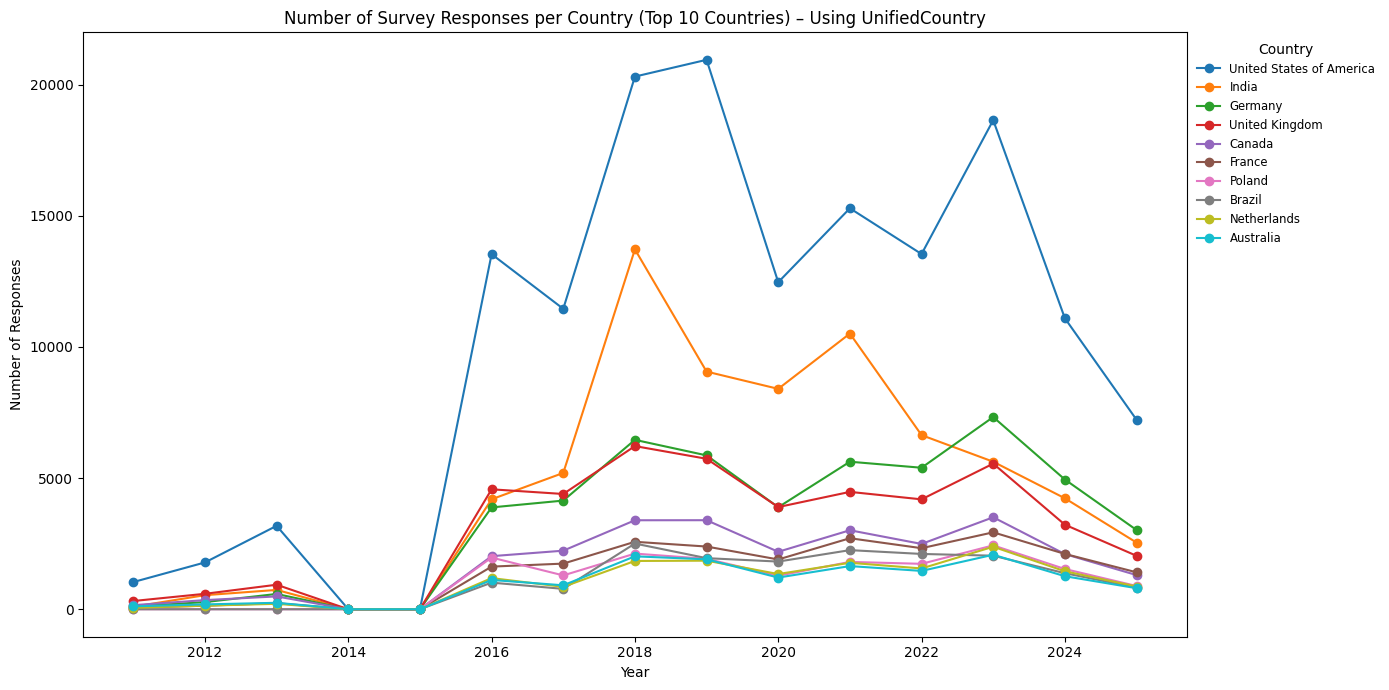

In [ ]:
# Assume all dfs[...] now have a column called 'UnifiedCountry' for country, preprocessed/standardized

# Build a DataFrame: index=year, columns=country, values=# rows (frequency)
country_freq = {}

for year, df_year in dfs.items():
    if "UnifiedCountry" in df_year.columns:
        counts = df_year["UnifiedCountry"].value_counts(dropna=True)
        # Remove counts for non-country string responses (e.g., null, 'Other', etc.)
        counts = counts[~counts.index.isin(['Response', 'Other', 'Other Countries', 'Other Country', 'Other (please specify)', 'Other Europe', None, float('nan')])]
        country_freq[year] = counts

# Aggregate list of all countries present in any year
all_countries = set()
for counts in country_freq.values():
    all_countries.update(counts.index)

all_countries = sorted(all_countries)
years_sorted = sorted(country_freq.keys())
freq_matrix = pd.DataFrame(0, index=years_sorted, columns=all_countries)

for year in years_sorted:
    for country in all_countries:
        if country in country_freq[year]:
            freq_matrix.loc[year, country] = country_freq[year][country]

# For clarity, only plot top N most common countries (optional)
N = 10
top_countries = freq_matrix.sum(axis=0).sort_values(ascending=False).head(N).index

plt.figure(figsize=(14, 7))
for country in top_countries:
    plt.plot(freq_matrix.index, freq_matrix[country], marker='o', label=country)

plt.xlabel("Year")
plt.ylabel("Number of Responses")
plt.title(f"Number of Survey Responses per Country (Top {N} Countries) – Using UnifiedCountry")
plt.legend(title="Country", loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize="small", frameon=False)
plt.tight_layout()
plt.show()


